# AMPL Lockdown Model

In [1]:
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
# Initialise AMPL environment
ampl = AMPL()

In [ ]:
# Set solver
ampl.setOption("solver", "ipopt")
ampl.setOption("presolve", "0")
ampl.setOption("presolve_assoc", "0")
ampl.setOption("substout", "0")
ampl.setOption("log_file", "AMPL_ipopt_log_presolve_assoc0.txt")
ampl.setOption("ipopt_options", "print_timing_statistics=yes")

In [4]:
# Define lockdown model in AMPL format
model = """
# Parameters
param beta := 0.5;      # Infectivity rate
param gamma := 0.25;    # Recovery rate
param v_max := 0.5;     # Maximum intervention
param v_total := 10.0;  # Maximum cost

param t0 := 0.0;
param tf := 100.0;
param dt := 2.0;

param S0 := 0.99;
param I0 := 0.01;
param C0 := 0.00;

param T := int(tf / dt);

# Variables
var S{t in 1..T+1} >= 0, <= 1;   # Susceptible
var I{t in 1..T+1} >= 0, <= 1;   # Infected
var C{t in 1..T+1} >= 0, <= 1;   # Cumulative infections
var v{t in 1..T+1} >= 0, <= v_max;   # Intervention

# Initial Conditions
subject to InitialConditionS: S[1] == S0;
subject to InitialConditionI: I[1] == I0;
subject to InitialConditionC: C[1] == C0;

# # Constraints on variables
# subject to S_bounds {t in 2..T+1}:
#     0 <= S[t] <= 1;

# subject to I_bounds {t in 2..T+1}:
#     0 <= I[t] <= 1;

# subject to C_bounds {t in 2..T+1}:
#     0 <= C[t] <= 1;

# subject to v_bounds {t in 1..T+1}:
#     0 <= v[t] <= v_max;
    
# Total intervention cost constraint
subject to TotalCostConstraint:
    dt * sum {t in 1..T+1} v[t] <= v_total;

# Nonlinear expressions for infection and recovery rates
var infection{t in 1..T} >= 0;
var recovery{t in 1..T} >= 0;

# Define infection and recovery explicitly as constraints
subject to DefineInfection {t in 1..T}:
    infection[t] = (1 - exp(-(1 - v[t]) * beta * I[t] * dt)) * S[t];

subject to DefineRecovery {t in 1..T}:
    recovery[t] = (1 - exp(-gamma * dt)) * I[t];

# Nonlinear differential equations
subject to SusceptibleConstraint {t in 1..T}:
    S[t+1] == S[t] - infection[t];

subject to InfectedConstraint {t in 1..T}:
    I[t+1] == I[t] + infection[t] - recovery[t];

subject to CumulativeInfectionConstraint {t in 1..T}:
    C[t+1] == C[t] + infection[t];

# Objective: Minimize cumulative infections at the final time
minimize TotalCumulativeInfections:
    C[T+1];
"""

In [5]:
# Load model
ampl.eval(model)

In [6]:
# Solve model
ampl.solve()
time.sleep(10)

Ipopt 3.14.17: print_timing_statistics=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      803
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:      250

Total number of variables............................:      304
                     variables with only lower bounds:      100
                variables with lower and upper bounds:      204
                     variables with only upper bounds:        0
Total number of equality constraints............

In [7]:
T = ampl.getParameter("T").value()
υ_total = ampl.getParameter("v_total").value()
υ_max = ampl.getParameter("v_max").value()
dt = ampl.getParameter("dt").value()
ts = np.arange(0, 100 + dt, dt)

# Calculate exact control time bounds
t1 = 14.338623046875002
t2 = t1 + υ_total / υ_max



In [8]:
# Retrieve results
S_opt = [ampl.getVariable("S").get(i).value() for i in range(1, T+2)]
I_opt = [ampl.getVariable("I").get(i).value() for i in range(1, T+2)]
C_opt = [ampl.getVariable("C").get(i).value() for i in range(1, T+2)]
υ_opt = [ampl.getVariable("v").get(i).value() for i in range(1, T+2)]

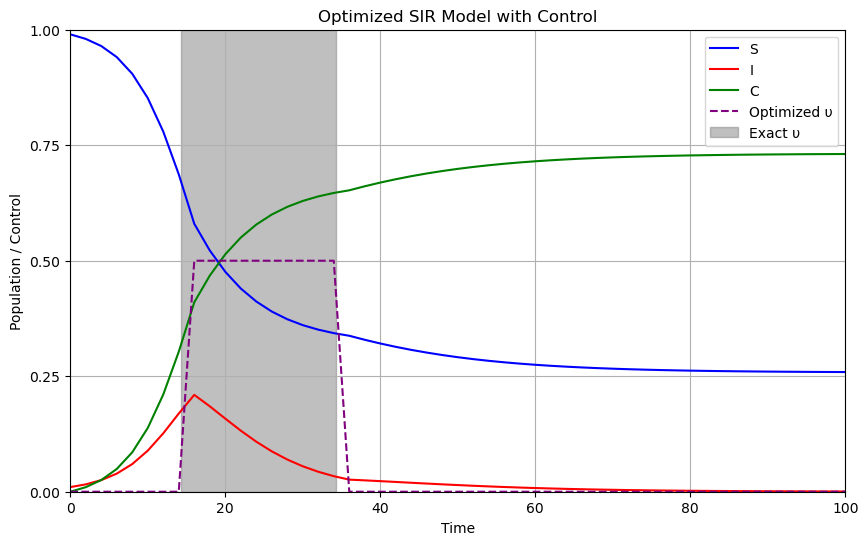

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ts, S_opt, label="S", color="blue")
plt.plot(ts, I_opt, label="I", color="red")
plt.plot(ts, C_opt, label="C", color="green")
plt.plot(ts, υ_opt, label="Optimized υ", color="purple", linestyle="dashed")
plt.axvspan(t1, t2, color="gray", alpha=0.5, label="Exact υ")
plt.xlabel("Time")
plt.ylabel("Population / Control")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step=0.25))
plt.xlim(0, 100)
plt.title("Optimized SIR Model with Control")
plt.legend()
plt.grid()
plt.show()

In [10]:
# Timesteps are consistent with the ones in the model
timesteps = np.arange(1, T + 2) 

# Extract values from the DataFrame using the index
data = pd.DataFrame({
    "timestep": timesteps,
    "S": S_opt,
    "I": I_opt,
    "C": C_opt,
    "υ": υ_opt
})

# Save to CSV
data.to_csv("amplpy_results.csv", index=False)

In [11]:
ampl.close()
